# Lab 6
### Daniel Mehta

## Apply all techniques you learned this week to train an LSTM and Bidirectional LSTM network on the "Frankenstein" dataset(Please download the dataset from Kaggle).

# Load Data

In [136]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Dense, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np

In [5]:
df = pd.read_csv("ZC.csv")

In [7]:
print("Shape of dataset:", df.shape)
print("\nColumn names:", df.columns.tolist())

Shape of dataset: (86, 2)

Column names: ['name', 'line']


In [12]:
df.head()

,name,line
0,Human,Human is the most dangerous race
1,Human,We rule the world
2,Human,Time to go to work
3,Human,Where are you from?))))
4,Human,Roadtrip!


# Extract Samples

In [28]:
# extract line column
lines =df['line'].astype(str).tolist()

In [30]:
# initiate tokenizer at word level
tokenizer =Tokenizer()
tokenizer.fit_on_texts(lines)

In [32]:
# generate input output sequence pairs
sequences = []
for line in lines:
    token_list =tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_seq = token_list[:i+1]
        sequences.append(n_gram_seq)

In [34]:
# pad sequences
max_seq_len=max(len(seq) for seq in sequences)
sequences = pad_sequences(sequences, maxlen=max_seq_len,padding='pre')

In [36]:
#split into input (X) and label (y)
sequences = np.array(sequences)
X =sequences[:, :-1] # input sequence
y =sequences[:, -1] # target (next word)

In [38]:
# One hot encode labels
vocab_size = len(tokenizer.word_index) +1
y = tf.keras.utils.to_categorical(y,num_classes=vocab_size)

In [40]:
print("X.shape:", X.shape)
print("y.shape:", y.shape)

X.shape: (370, 14)
y.shape: (370, 224)


# Train Test split

In [47]:
# 90 / 10 split
train_data, test_data, train_labels, test_labels = train_test_split(X, y,test_size=0.1,random_state=5500)

In [59]:
# Adding 3rd dimension
train_data = np.expand_dims(train_data, axis=-1)
test_data = np.expand_dims(test_data, axis=-1)

---

# LSTM

## Create Model (LSTM)

In [121]:
i = Input(shape=(train_data[0].shape[0], 1)) # Input shape
x = LSTM(128)(i) # 128 LSTM units
x = Dense(vocab_size, activation='softmax')(x) #Predict next word
model = Model(i, x)

## Complie the model

In [123]:
model.compile(optimizer=Adam(learning_rate=0.001), # adaptave 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Train

In [125]:
# Train Model
hist = model.fit(train_data, train_labels,
                 validation_data=(test_data, test_labels),
                 epochs=50)

Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.0084 - loss: 5.4681 - val_accuracy: 0.0000e+00 - val_loss: 5.4498
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0346 - loss: 5.2952 - val_accuracy: 0.0811 - val_loss: 5.4377
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0262 - loss: 5.0582 - val_accuracy: 0.1081 - val_loss: 5.4661
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.0349 - loss: 4.8853 - val_accuracy: 0.1081 - val_loss: 5.6514
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0521 - loss: 4.7779 - val_accuracy: 0.0541 - val_loss: 5.7900
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0850 - loss: 4.5835 - val_accuracy: 0.0270 - val_loss: 5.8358
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0881 - loss: 4.5148 - val_accuracy: 0.0541 - val_loss: 5.9520
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0738 - loss: 4.4604 - val_accuracy: 0.0270

## Plot

In [129]:
trainAcc = [100 * x for x in hist.history['accuracy']]
testAcc = [100 * x for x in hist.history['val_accuracy']]

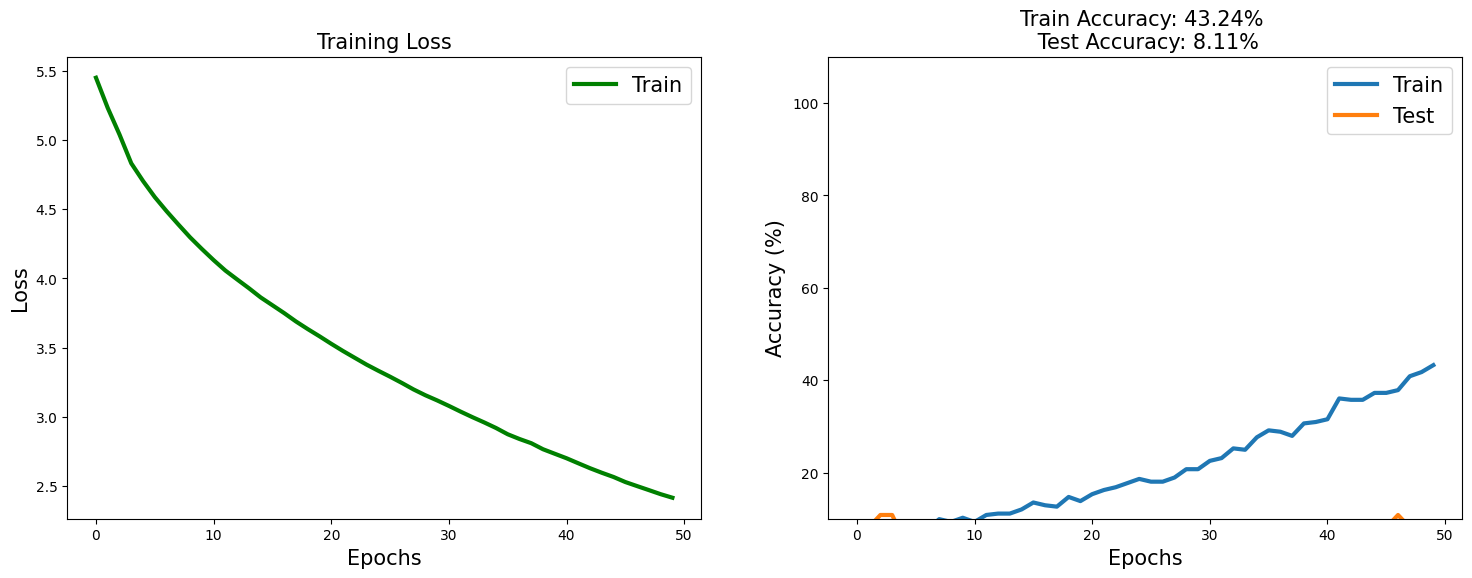

In [131]:
fig,ax = plt.subplots(1,2,figsize=(18,6))

# Loss plot
ax[0].plot(hist.history['loss'], 'g', lw = 3, label = 'Train')
ax[0].set_xlabel('Epochs', fontsize = 15)
ax[0].set_ylabel('Loss', fontsize = 15)
ax[0].legend(fontsize = 15)
ax[0].set_title('Training Loss', fontsize = 15)

# Accuracy plot
ax[1].plot(trainAcc, label ='Train', lw = 3)
ax[1].plot(testAcc, label ='Test', lw = 3)
ax[1].set_xlabel('Epochs', fontsize = 15)
ax[1].set_ylabel('Accuracy (%)', fontsize = 15)
ax[1].set_ylim([10,110])
ax[1].set_title(f'Train Accuracy: {trainAcc[-1]:.2f}% \n Test Accuracy: {testAcc[-1]:.2f}%', fontsize = 15)
ax[1].legend(fontsize = 15)

plt.show()

---

# Bidirectional LSTM

## Create the Model

In [138]:
i = Input(shape=(train_data.shape[1], 1)) #shape = (timesteps, features)
x = Bidirectional(LSTM(128))(i)
x = Dense(vocab_size, activation='softmax')(x)
model_bi = Model(i, x)

## Compile

In [145]:
model_bi.compile(optimizer=Adam(learning_rate=0.001),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

## Train

In [147]:
hist_bi = model_bi.fit(train_data, train_labels,
                       validation_data=(test_data, test_labels),
                       epochs=50)

Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.0113 - loss: 5.4221 - val_accuracy: 0.0541 - val_loss: 5.3923
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0514 - loss: 5.0802 - val_accuracy: 0.0270 - val_loss: 5.4538
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.0679 - loss: 4.8393 - val_accuracy: 0.0000e+00 - val_loss: 5.6894
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.0567 - loss: 4.7085 - val_accuracy: 0.0000e+00 - val_loss: 5.8226
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.0588 - loss: 4.5686 - val_accuracy: 0.0000e+00 - val_loss: 5.9658
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0714 - loss: 4.5500 - val_accuracy: 0.0000e+00 - val_loss: 6.1119
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.0896 - loss: 4.3622 - val_accuracy: 0.0000e+00 - val_loss: 6.2844
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.1035 - loss: 4.2337 - val_

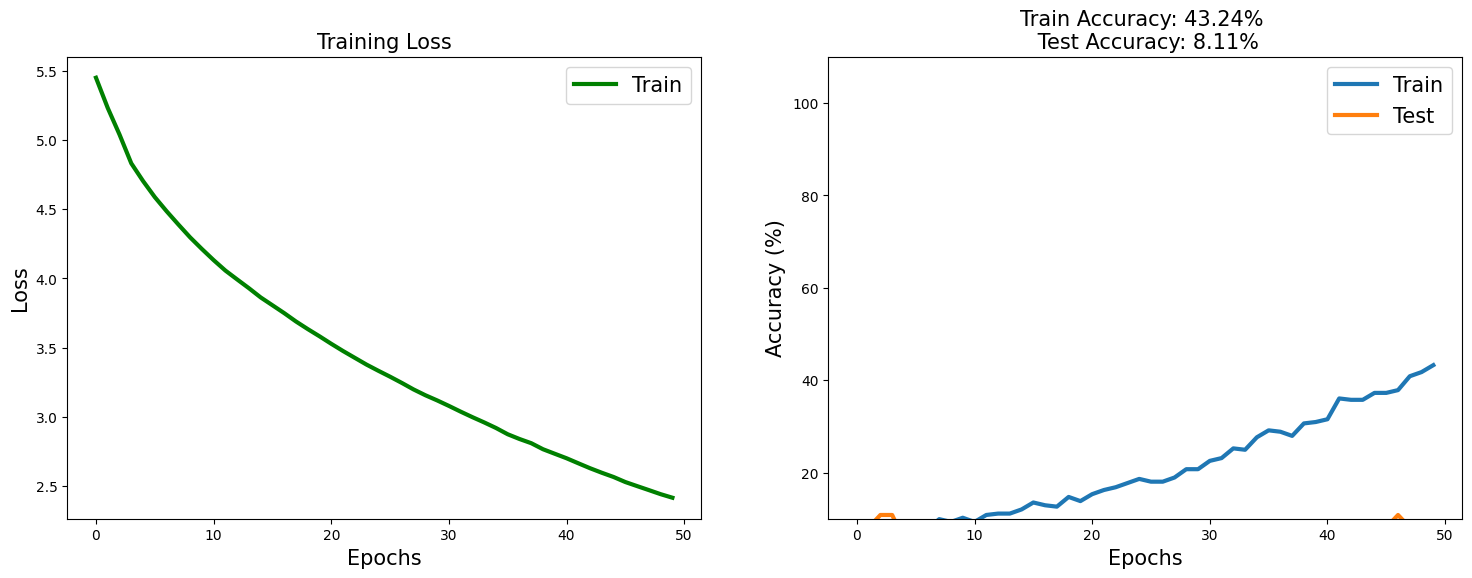

In [154]:
fig,ax = plt.subplots(1,2,figsize=(18,6))

# Loss plot
ax[0].plot(hist.history['loss'], 'g', lw = 3, label = 'Train')
ax[0].set_xlabel('Epochs', fontsize = 15)
ax[0].set_ylabel('Loss', fontsize = 15)
ax[0].legend(fontsize = 15)
ax[0].set_title('Training Loss', fontsize = 15)

# Accuracy plot
ax[1].plot(trainAcc, label ='Train', lw = 3)
ax[1].plot(testAcc, label ='Test', lw = 3)
ax[1].set_xlabel('Epochs', fontsize = 15)
ax[1].set_ylabel('Accuracy (%)', fontsize = 15)
ax[1].set_ylim([10,110])
ax[1].set_title(f'Train Accuracy: {trainAcc[-1]:.2f}% \n Test Accuracy: {testAcc[-1]:.2f}%', fontsize = 15)
ax[1].legend(fontsize = 15)

plt.show()